In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from mnist import MNIST
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
# load data
mndata = MNIST('./python-mnist/data/')

X_train, y_train = mndata.load_training()
X_test, y_test = mndata.load_testing()

# convert into numpy objects
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

## High-level discription of protype selection for 1-NN

To select the best prototypes representative of the entire dataset, we use the distribution of points under each label and find a subset of points were they are most dense. These subsets of points in each label are then used as prototypes.

## Pseudocode

Let $S$ denote the subset of training data (prototypes), $X_{i}$ denote the data corresponding to label $i$ and $C_{i}$ denote the cluster centers of label $i$ found by kmeans algorithm. Then below is psueedo code to implement prototype selection for 1-NN:

Input: $X$, $M$

Output: $S \subset X$ of size $M$ (e.g prototypes)

for $i = 0,1,2,\dots,9$:

$\hspace{10mm}C_{i} \leftarrow $ kmeans($X_{i}$, $\frac{m}{10}$) # find cluster centers of data with label $i$
 
$\hspace{10mm}S \leftarrow S \cup C_{i}$ # keep cluster centers as the prototpes for label $i$

This algorithm should find a condensed version of the training data of size $M$ that will maintain and outperform a uniformily random selection of the training data of also size $M$. I experiment with subsets of size $M = 1000, 5000, 10000$ and compare the accuracies of 1-NN classifier on MNIST data.

In [16]:
def accuracy(y, y_pred):
    return np.sum(1*(y_pred == y))/len(y)

def get_error(data):
    
    n = len(data)
    t = 2.776 # 95 percent confidence interval
    mean, sigma = np.mean(data), np.std(data)
    bound_1 = mean + t*sigma/np.sqrt(n)
    bound_2 = mean - t*sigma/np.sqrt(n)
    
    return abs(bound_1 - bound_2)

class PrototypeSelector:
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def get_prototypes(self, method, size):

        if  method == 'random':
            indicies = np.random.permutation(self.X.shape[0])[0:M]
            return self.X[indicies,:], self.y[indicies]
      
        if method == 'prototype':            
            
            x_samples, y_samples = [], []
            for class_ in range(num_classes):
                indicies = [i for i,val in enumerate(1*self.y == class_) if val == 1]
                k_means = MiniBatchKMeans(n_clusters = int(M/10)).fit(self.X[indicies])

                x_samples.append(k_means.cluster_centers_) # use cluster centers
                y_samples.append(self.y[indicies][0:int(M/10)])
            
        return np.concatenate(x_samples), np.concatenate(y_samples)

In [36]:
M_vals = [1000, 5000,10000]
num_iter = 5 # due to random nature in experiment, perform 5 times for CI calculation
num_classes = 10

# data collector for experiments
random_errs_collector = []
prototype_errs_collector = []

random_accs_collector = []
prototype_accs_collector = []

selector = PrototypeSelector(X_train, y_train)
for M in tqdm(M_vals):
    
    random_accuracies, prototype_accuracies = [], []
    for iteration in range(num_iter):    
       
        # uniformly random selected subset
        X_rand, y_rand = selector.get_prototypes('random', M)
        random_model   = KNeighborsClassifier(n_neighbors=1).fit(X_rand, y_rand)
        y_pred         = random_model.predict(X_test)
        random_accuracies.append(accuracy(y_test, y_pred))

        
        # prototype selection
        X_rand, y_rand  = selector.get_prototypes('prototype', M)
        prototype_model = KNeighborsClassifier(n_neighbors=1).fit(X_rand, y_rand)
        y_pred          = prototype_model.predict(X_test)
        prototype_accuracies.append(accuracy(y_test, y_pred))
    
    # get confidence intervals errors on accuracy
    random_errs_collector.append(get_error(random_accuracies))
    prototype_errs_collector.append(get_error(prototype_accuracies))
    
    # average accuracy over trials for each M
    random_accs_collector.append(np.mean(random_accuracies))
    prototype_accs_collector.append(np.mean(prototype_accuracies))







  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Experimental Results

We compared the overall performance of 1-NN on the subsets of data produced by the prototype selection algorithm discussed above to that of a uniformily random selected subset of size $M$. We compare model performance of subsets of size $M = 1000, 5000, 10000$. Because of the randomness in selection, I performed $n = 5$ trials of each test to obtain a $95\%$ confidence inerval on the accuracies of the model using the formula:

$$
\bar{X} \pm t\frac{s}{\sqrt{n}}
$$

Where $\bar{X}$ is the sample mean, $s$ is the sample variance, and $n$ is the number of trials. The $t$ score for a problem with $n - 1 = 4$ degrees of freedom and level of significance $\alpha=0.025$ is given by $t = 2.776$. Below is the plot, along with the error bars of the accuracies of the models over all configurations of the experiment.

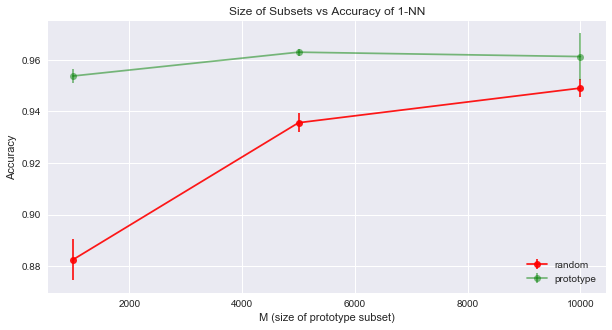

In [35]:
import seaborn
plt.figure(figsize=(10,5))
plt.title('Size of Subsets vs Accuracy of 1-NN')
plt.errorbar(M_vals, random_accs_collector, yerr=random_errs_collector, fmt='ro-', label='random', alpha=0.9)
plt.errorbar(M_vals, prototype_accs_collector, yerr=prototype_errs_collector, fmt='go-', label='prototype', alpha=0.5)
plt.legend(loc='lower right')
plt.xlabel('M (size of prototype subset)')
plt.ylabel('Accuracy')
plt.show()

## Conclusion

This prototype selection method is a clear imporvement over random selection. We are able to maintain and improve the accuracy of 1-NN. One thing to note: as the size $M$ of the subsets of data increase, there is more uncertainty in the accuracy of the prototype model. One reason for this could be: there is more data corresponding to each label and finding $\frac{M}{10}$ clusters in the data could result in unhelpful representations of the data (e.g noise). This shows us that there is still room for improvement. The prototype scheme may be changed slightly to only consider clusters that are closest/furthest fromt he boundary. We could also experiment with different metrics of distance which could also imporve the accuracy and certainty in our predictions.